Resolving ODE with machine learning

Considere the following ordinary differential equation:
$$(1)\quad \forall x\in [0,1]\quad g'(x)+g(x)=0 \quad g(0)=1.$$
One can show that the solution of this equation is unic and given by
$$\phi: x\mapsto e^{-x}.$$

The goal of this short notebook is to compare euler method and different architectures of neuronal networks that are able to "solve" this equation.

# Euler method:

But first let's start with one of the classical numerical method, the Euler method.
The idea behind this method is to say that, since for $x\in C^1$
$$x^{\prime}(t):=\lim_{h\to 0}\frac{x(t+h)-x(t)}{h},$$ then one can approximate
$x^{\prime}(t)$ by $\frac{x(t+h)-x(t)}{h}$ for $h$ sufficiently small.
Now if one want to solve $$\forall t\in [0,1]\quad x^{\prime}(t)=F(x(t),t),\quad x(0)=1,$$ one use the previous approximation to find
$$x(t+h)\approx x(t)+hF(x(t),t).$$
So, given a function $F$, $(t_1,t_2,...,t_N)$ a subdivision of $[0,1]$ and $h>0$, we have
$$\forall k\in [1,N]\quad x(t_{k}+h)=x(t_k)+hF(x(t_k),t_k).$$

In our case:
$$F : x\mapsto -x, \forall k\in [0,1000]\quad t_k=\frac{k}{N}\quad h=1/1000.$$



Source: https://www.pnw.edu/wp-content/uploads/2020/03/Lecture-Notes-10-5.pdf

Let's code it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

In [2]:
def true_sol(t):
  """

  Args:
    t: time

  Returns: exp(-t) solution of the equation (1)

  """
  return np.exp(-t)
def euler(N=10000):
  #N number of sub division of [0,1]
  h=1/N
  x=np.zeros(N)
  x[0]=1 #initial condition
  for k in range(N-1):
    x[k+1]=x[k]-h*x[k]
  #Returns: list of (approx(t) for t in subdivision) where approx(t) is the approximation of the true solution
  return x

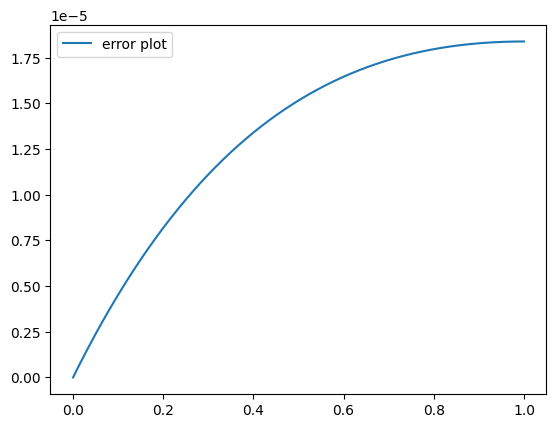

In [3]:
plt.figure()
subdivision=[k/10000 for k in range(10000)]
#plt.plot(subdivision, euler())
#plt.plot(subdivision, [true_sol(t) for t in subdivision])
plt.plot(subdivision, np.abs(np.array([true_sol(t) for t in subdivision])-np.array(euler())), label='error plot')
plt.legend()
plt.show()

# Can neuronal network approximate the ODE (1) solution ?

Now, the idea is to find a neuronal network that approximate the solution of $(1)$.

We are looking for parameters $\Theta=(\theta_1,\theta_2)$ and $\beta=(b_1,b_2)$ such that if
$$g_{\Theta,β}(t):=f_{1}(f_{2}(\theta_1 t+b_1) \theta_2+b_2)$$ where $f_1$ and $f_2$ are two given activations functions, one has
$$g_{\Theta,β}^{\prime}+g_{\Theta,β}\approx 0 \quad g_{\Theta,β}(0)\approx 1.$$
To do so, one define the loss
$$L_{\lambda}(\Theta,\beta):=\frac{1}{N}\sum_{1\leq i\leq N}(g_{\Theta,β}^{\prime}(x_i)+g_{\Theta,β}(x_i))^2+\lambda (g_{\Theta,β}(0)-1)^2.$$
Where $$\forall i\in [1,N]\quad x_i:=\frac{i}{N}.$$

Notice that here, in the loss $L_\lambda$ we have a terme $\lambda (g_{\Theta,\beta}(0)-1)^{2}$ which corresponds to initial condition. Actually, this is one way to encode intial condition, another way would be to search a solution $g_{\theta, \beta}$ that by construction is equal to the initial condition, see the pionier work of  	I. E. Lagaris, A. Likas, D. I. Fotiadis;
https://doi.org/10.48550/arXiv.physics/9705023. They suggest to find a solution of the form $$m: x\mapsto A(x) +xg_{\theta,\beta}(x),$$ where $A$ verifies the initial condition assuming the initial condition is of the form $g(0)=\alpha$.  

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

As a first neuronal network we choose the Multilayer-Perceptron (MLP), the simplest one from the feedforward neuronal network classe.


In [6]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP,self).__init__()
    self.fc1 = nn.Linear(1, 200) #(input_size, hidden_size)
    self.fc2 = nn.Linear(200, 1) #(input_size, hidden_size)

  def forward(self, t):
    x = torch.sigmoid(self.fc1(t))
    return self.fc2(x)

Mathematically speaking the above MLP is defined by:
$$\forall t\in \mathbb{R}\quad \forall i \in [1,q:=hidden size]\quad u_{i}=w_{i}t+b_{i}$$
$$g_{\theta,\beta}(t)=\sigma\left(\sum_{1\leq i\leq q}w_{i}t+b_{i}\right)=\sigma(t\theta\mathbb{1}^{T}+\beta)\quad \theta=(w_1,...,w_q)\quad \beta=(b_1,...,b_q).$$

Where:
$$\sigma : x\mapsto \frac{1}{1+e^{-x}}.$$

The resnet, noted $Res$ is a neuronal network which can be written as:
$$Res : x\mapsto f(x)+x,$$ where $f$ is a neuronal network, in our case $f=MLP$.

In [7]:
class Resnet(nn.Module):
  def __init__(self):
    super(Resnet,self).__init__()
    self.fc1 = nn.Linear(1, 10)
    self.fc2 = nn.Linear(10, 1)

  def forward(self, t):
    x = torch.sigmoid(self.fc1(t))
    return self.fc2(x)+t

x^{\prime \prime}

In [8]:
def loss_fn(model,t):
  t.requires_grad_(True)
  x=model(t)
  x_prime = torch.autograd.grad(outputs=x, inputs=t,
                                   grad_outputs=torch.ones_like(x),
                                   create_graph=True)[0]
  loss1 = (x_prime + x) ** 2
  loss2 = (model(torch.tensor([[0.0]])) - 1) ** 2

  return torch.mean(loss1) + loss2
def loss_degre_2(model,t):
  t.requires_grad_(True) #activation of the gradient w.r.t to t
  x=model(t) #neuronal network we want to plug in
  x_prime=torch.autograd.grad(outputs=x, inputs=t,
                              grad_outputs=torch.ones_like(x)
                              , create_graph=True)[0]
  x_prime_prime=torch.autograd.grad(outputs=x_prime, inputs=t,
                              grad_outputs=torch.ones_like(x)
                              , create_graph=True)[0]
  loss_ode=(x_prime_prime+x)**2
  condition_init_loss=(model(torch.tensor([[0.0]])) - 0)**2
  return torch.mean(loss_ode)+condition_init_loss


Here we have coded:
$$L_{1}(\Theta,\beta):=\frac{1}{N}\sum_{1\leq i\leq N}(g_{\Theta,β}^{\prime}(x_i)+g_{\Theta,β}(x_i))^2+ (g_{\Theta,β}(0)-1)^2.$$
$$L_{2}(\Theta,\beta):=\frac{1}{N}\sum_{1\leq i\leq N}(g_{\Theta,β}^{\prime \prime}(x_i)+g_{\Theta,β}(x_i))^2+ (g_{\Theta,β}(0)-0)^2.$$
Where $$\forall i\in [1,N]\quad x_i:=\frac{i}{N}.$$

In [9]:
def train(model, loss_fct):
  loss_values=[]
  optimizer = optim.Adam(model.parameters(), lr=0.1)
  for epoch in range(10000):
    optimizer.zero_grad()
    t = torch.linspace(0, 1, 500).view(-1, 1) #Training is on [0,1]
    loss= loss_fct(model,t)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Époch {epoch}: Loss = {loss.item()}')
        loss_values.append(loss.item())

In [10]:
"for each f=MLP or Resnet we store x_VALUES containes f(t) for t in range [0,10]"
x_VALUES=[]
t_values = torch.linspace(0, 20, 500).view(-1, 1)
MODELS=[MLP(),Resnet()]
for model in MODELS:
  train(model, loss_fct=loss_fn)
  x_values = model(t_values).detach().numpy()
  x_VALUES.append(x_values)

Époch 0: Loss = 1.629171371459961
Époch 100: Loss = 0.0026571685448288918
Époch 200: Loss = 0.0007118309731595218
Époch 300: Loss = 0.00034688872983679175
Époch 400: Loss = 0.00018031653598882258
Époch 500: Loss = 0.00011731460836017504
Époch 600: Loss = 9.611152927391231e-05
Époch 700: Loss = 8.839878864819184e-05
Époch 800: Loss = 8.414549665758386e-05
Époch 900: Loss = 8.053382771322504e-05
Époch 1000: Loss = 7.694085797993466e-05
Époch 1100: Loss = 7.327379717025906e-05
Époch 1200: Loss = 6.953910633455962e-05
Époch 1300: Loss = 6.575867882929742e-05
Époch 1400: Loss = 6.195367313921452e-05
Époch 1500: Loss = 5.814503674628213e-05
Époch 1600: Loss = 5.4351963626686484e-05
Époch 1700: Loss = 5.0593043852131814e-05
Époch 1800: Loss = 4.688590342993848e-05
Époch 1900: Loss = 4.324687324697152e-05
Époch 2000: Loss = 3.969192403019406e-05
Époch 2100: Loss = 3.6235840525478125e-05
Époch 2200: Loss = 3.289320011390373e-05
Époch 2300: Loss = 2.967757791338954e-05
Époch 2400: Loss = 2.66011

In [22]:
#for model in MODELS:
#  print(f"\n Optimal weights {model}:")
#  for name, param in model.named_parameters():
#    print(f"{name}: {param.data.numpy()}")

<ipython-input-12-5f31f1612fec>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/MLP_BEST_model_weights.pth')) #be carreful with t

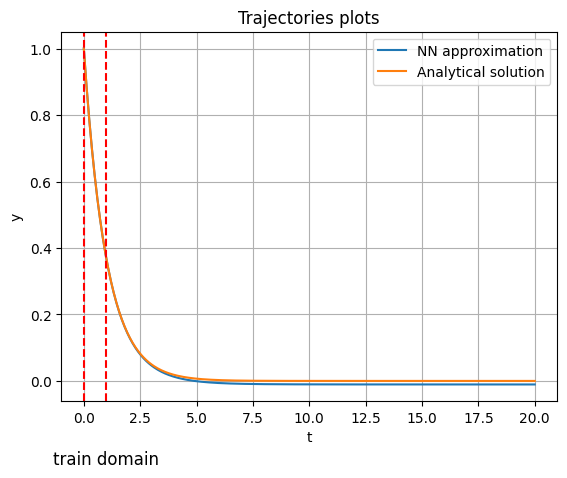

In [12]:
#If you want to use "optimal" weights for MLP use this cell:
model=MLP()
model.load_state_dict(torch.load('/content/MLP_BEST_model_weights.pth')) #be carreful with the file path
model.eval
t_values = torch.linspace(0, 20, 500).view(-1, 1)
MLP_optimal_values=model(t_values).detach().numpy()

# plot section
plt.plot(t_values.numpy(), MLP_optimal_values, label=f'NN approximation')
plt.plot(t_values.numpy(), [true_sol(t) for t in t_values.numpy()], label='Analytical solution')
#plt.plot(t_values.numpy(), [np.sin(t) for t in t_values.numpy()], label='Analytical solution')

plt.xlabel('t')
plt.ylabel('y')
plt.title('Trajectories plots')

plt.axvline(x=0, color='red', linestyle='--')  # red vertical axis for x=0
plt.axvline(x=1, color='red', linestyle='--')  # red vercital axis for x=1
plt.text(1, -0.25, 'train domain', horizontalalignment='center', fontsize=12)


plt.legend()
plt.grid()
plt.savefig("MLP_xprime_x")
plt.show()

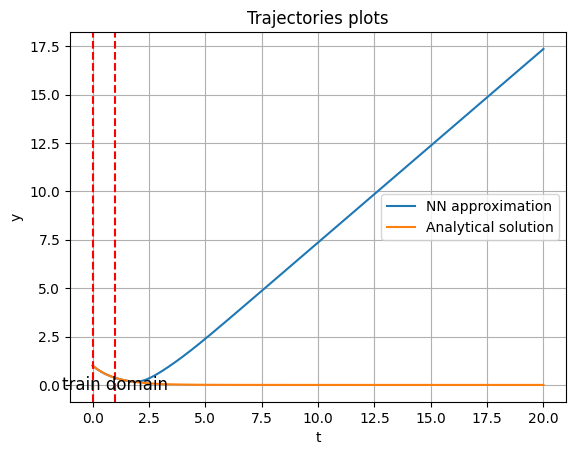

In [13]:
# graphical check of the validity of the solution
t_values = torch.linspace(0, 20, 500).view(-1, 1)
x_values = x_VALUES[1]

# plot section
plt.plot(t_values.numpy(), x_values, label=f'NN approximation')
plt.plot(t_values.numpy(), [true_sol(t) for t in t_values.numpy()], label='Analytical solution')
#plt.plot(t_values.numpy(), [np.sin(t) for t in t_values.numpy()], label='Analytical solution')

plt.xlabel('t')
plt.ylabel('y')
plt.title('Trajectories plots')

plt.axvline(x=0, color='red', linestyle='--')  # red vertical axis for x=0
plt.axvline(x=1, color='red', linestyle='--')  # red vercital axis for x=1
plt.text(1, -0.25, 'train domain', horizontalalignment='center', fontsize=12)


plt.legend()
plt.grid()
plt.show()

In [52]:
t_values.max().detach().numpy()

11.0

We can see that both MLP and Resnet(MLP) architectures are able to approximate the true solution on the train domain.
What can we say outside the training domain ?
To do so, we propose a metric to measure how close is our solution to the "true" one.

Assume $f$ is the analitical solution and $\phi$ is the neuronal network that we trained on $[0,T]$.

For any $ɛ>0$ we define $$T_ɛ(\phi):=\sup\left\{t\geq T: \quad  \left|\phi-f \right|<ɛ \right\}.$$

We can see that $$\forall \varepsilon>0\quad T_{ɛ}(MLP)>T_{ɛ}(Resnet).$$

Notice that with this "metric" a neuronal network $\phi$ can generalize over a time horizon $T^{\prime}>T$ if
$$\forall \epsilon>0 \quad T_{ɛ}(\phi)=T^\prime.$$

In [ ]:
#saving "best weights"
#torch.save(MODELS[0].state_dict(), 'model_weights.pth')

In [15]:
#store the values of each neuronal network
values_MLP=MLP_optimal_values
values_Resnet=x_VALUES[1]


def difference(f,g):
  return np.abs(f-g)

f=[true_sol(t) for t in t_values.numpy()] #analytical solution
diff=difference(f,values_Resnet)
Epsilon=[1/(k+1) for k in [1,10,100,1000,10000]] #epsilon value in the formula above

time=t_values.numpy()
diff_resnet=difference(f,values_Resnet)
diff_MLP=difference(f,values_MLP)
#print(diff_MLP)
T_MLP=[]
T_resnet=[]
for eps in Epsilon:
  index_resnet=np.where(diff_resnet<eps)[0]
  index_mlp=np.where(diff_MLP<eps)[0]
  time_mlp=time[np.max(index_mlp)][0] #T_epsilon(MLP)
  if np.size(index_resnet)==0:
    time_resnet=t_values.max().detach().numpy()
  time_resnet=time[np.max(index_resnet)][0] #T_epsilon(Resnet)
  T_MLP.append(time_mlp) #store the values
  T_resnet.append(time_resnet) #store the values



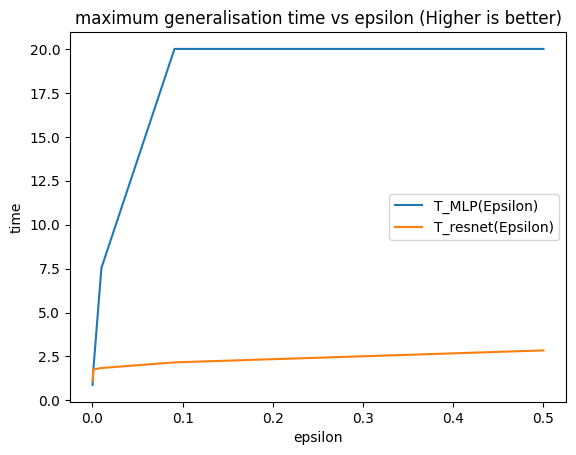

In [17]:
#Plot
plt.figure()
plt.plot(Epsilon, T_MLP, label='T_MLP(Epsilon)')
plt.plot( Epsilon,T_resnet, label='T_resnet(Epsilon)')
plt.title('maximum generalisation time vs epsilon (Higher is better)')
plt.xlabel("epsilon")
plt.ylabel("time")
plt.legend()
plt.savefig('maximum_generalisation_time_xprime_x_MLP')
plt.show()